# 1

In [1]:
install.packages('rpart')
install.packages('mlbench')
install.packages('adabag')

Installing package into ‘/usr/local/lib/R/4.0/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/4.0/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/4.0/site-library’
(as ‘lib’ is unspecified)



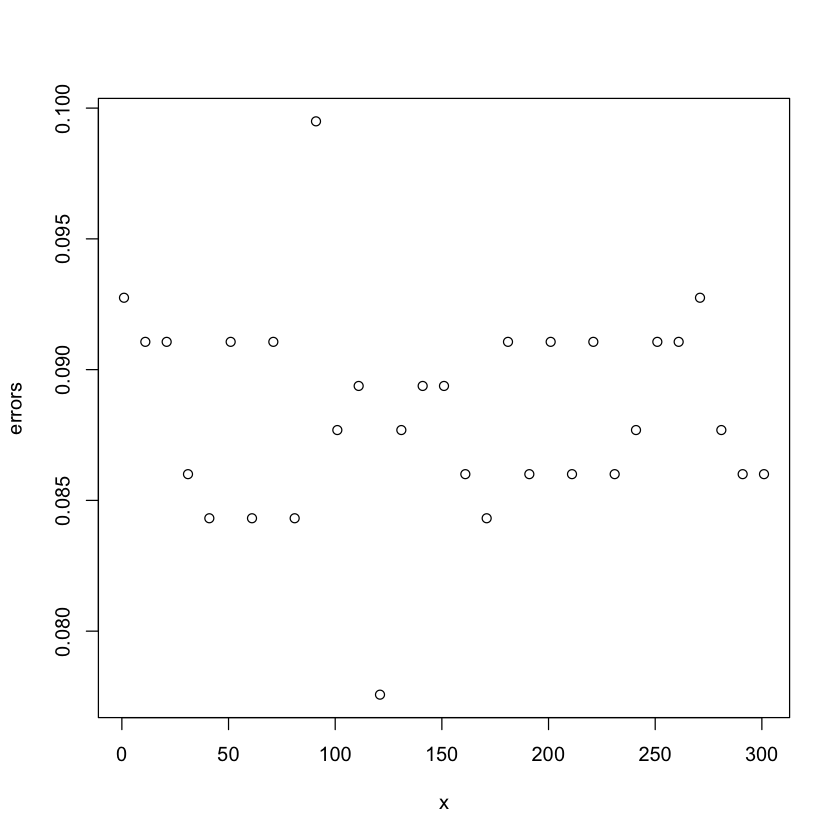

In [4]:
library(rpart)
library(mlbench)
library(adabag)
data(Vehicle)

#separate data for train and test
get_train_test <- function(data, persentage) {
    size = dim(data)[1]
    set.seed(12345)
    randomized = data[order(runif(size)), ]
    train_sep = as.integer(size * persentage / 100)
    test_sep = as.integer(size * (1 - persentage / 100))
    list(randomized[1 : train_sep, ], randomized[(test_sep + 1) : size, ])
}

#test the function
separated_data = get_train_test(Vehicle, 70)
train = separated_data[[1]]
test = separated_data[[2]]

maxdepth = 5
x = seq(1,301,by=10)

errors = sapply(x, function(x) {
    Vehicle.adaboost = boosting(Class ~., data=train, mfinal=i, maxdepth=maxdepth)
    Vehicle.adaboost.pred = predict.boosting(Vehicle.adaboost, newdata=test)
    Vehicle.adaboost.pred$error
})

plot(x, errors)

# 2

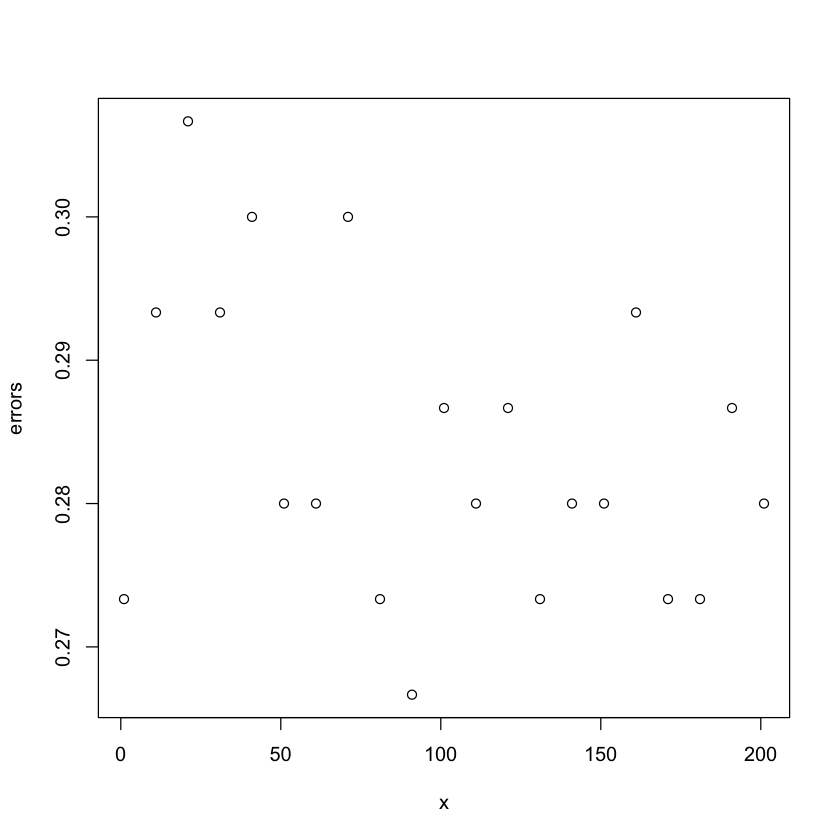

In [5]:
library(mlbench)
library(adabag)
data(Glass)

#separate data for train and test
get_train_test <- function(data, persentage) {
    size = dim(data)[1]
    set.seed(12345)
    randomized = data[order(runif(size)), ]
    train_sep = as.integer(size * persentage / 100)
    test_sep = as.integer(size * (1 - persentage / 100))
    list(randomized[1 : train_sep, ], randomized[(test_sep + 1) : size, ])
}

#test the function
separated_data = get_train_test(Glass, 70)
train = separated_data[[1]]
test = separated_data[[2]]

maxdepth = 5
x = seq(1, 201,by=10)

errors = sapply(x, function(x) {
    Glass.bagging = bagging(Type ~., data=train, mfinal=i, maxdepth=maxdepth)
    Glass.bagging.pred = predict.bagging(Glass.bagging, newdata=test)
    Glass.bagging.pred$error
})

plot(x, errors)

# 3

In [6]:
knn_w <- function(target, train, k, w)
  return(list(target = target, train = train, levels = levels(train[, target]), k = k, w = w))

knn_w_predicted <- function(clfier, testdata) {
    n = nrow(testdata)
    pred = rep(NA_character_, n)
    trainlabels = clfier$train[, clfier$target]

    train <- clfier$train[, !(names(clfier$train) %in% clfier$target)]
    test <- testdata[, !(names(testdata) %in% clfier$target)]

    for (i in 1:n) {
        n_number = order(apply(train, 1, function(x)
        sum((test[i,] - x)^2)))[1:clfier$k]

        myfreq <- data.frame(names = clfier$levels,
        freq = rep(0, length(clfier$levels)))
        for (t in n_number) {
            myfreq[myfreq$names == trainlabels[t], ][2] <- myfreq[myfreq$names == trainlabels[t],][2] + clfier$w[t]
        }
        most_frequent = clfier$levels[myfreq$freq ==
        max(myfreq$freq)]
        pred[i] = sample(most_frequent, 1)
    }

    factor(pred, levels = levels(trainlabels))
}
                               
knn_boosting <- function(target,
                        data,
                        k = 11,
                        mfinal = 1,
                        ...) {
    n <- nrow(data)
    w <- rep(1/n, each = n)

    classifiers <- list()

    alphas <- vector()
    for (t in 1:mfinal) {
        clfier <- knn_w(target, train = data, k = k, w)
        knn_predicted <- knn_w_predicted(clfier, data)
        error <- vector()
        for (i in 1:n) {
            if (data[[target]][i] != knn_predicted[i]) 
                 error <- append(error, w[i])
        }

        if (sum(error) >= 0.5) {
            break()
        }

        classifiers[[t]] <- clfier
        alphas[[t]] <- log((1 - sum(error)) / sum(error)) / 2
        for (i in 1:n) {
            if (knn_predicted[i] != data[[target]][i]) {
                w[i] <- w[i]*exp(alphas[[t]])
            } else{
                w[i] <- w[i]*exp(-alphas[[t]])
            }
        }
    }

    result <- list()

    result$classifiers <- classifiers
    result$alphas <- alphas
    result$levels <- levels(data[, target])
    return(result)
}

boosting_pred <- function(clfier, testdata) {
    n <- nrow(testdata)
    pred = rep(NA_character_, n)

    for (i in 1:n) {
        myfreq <- data.frame(names = clfier$levels,
        freq = rep(0, length(clfier$levels)))

        for (j in 1:length(clfier$classifiers)) {
            prediction <- knn_w_predicted(clfier$classifiers[[j]], testdata[i, ])
            myfreq[myfreq$names == prediction, ][2] <- myfreq[myfreq$names == prediction, ][2] +
            clfier$alphas[j]
        }

        most_frequent = clfier$levels[myfreq$freq == max(myfreq$freq)]
        pred[i] <- sample(most_frequent, 1)
    }
    factor(pred, levels = clfier$levels)
}

In [7]:
data("Glass")

train.ratio = 0.7
n <- dim(Glass)[1]
n.train <- as.integer(n * train.ratio)

rand <- Glass[order(runif(n)), ]
train <- rand[1:n.train, ]
test <- rand[(n.train + 1):n, ]
rpart <- rpart(Type ~ ., data = train, maxdepth = 5)
rpart_pred <- predict(rpart, test, type = 'class')

tbl_rpart <- table(rpart_pred, test$Type)

1 - (sum(diag(tbl_rpart)) / sum(tbl_rpart))

clfier <- knn_boosting('Type', train, mfinal = 1)
pred <- boosting_pred(clfier, test)
tbl_knn <- table(test$Type, pred)

1 - sum(diag(tbl_knn)) / sum(tbl_knn)

[1] 0.3538462

[1] 0.4923077

In [10]:
data(Vehicle)

n <- nrow(Vehicle)
n.train <- as.integer(n * train.ratio)

rand <- Vehicle[order(runif(n)), ]
train <- rand[1:n.train, ]
test <- rand[(n.train + 1):n, ]
rpart <- rpart(Class ~ ., data = train, maxdepth = 5)
rpart_pred <-
predict(rpart, newdata = test, type = 'class')

tbl_rpart <- table(rpart_pred, test$Class)

1 - (sum(diag(tbl_rpart)) / sum(tbl_rpart))

clfier <- knn_boosting('Class', train, mfinal = 1)
pred <- boosting_pred(clfier, test)
tbl_knn <- table(test$Class, pred)

1 - sum(diag(tbl_knn)) / sum(tbl_knn)

[1] 0.2784314

[1] 0.3568627